In [2]:
import cv2
import matplotlib.colors as cs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image

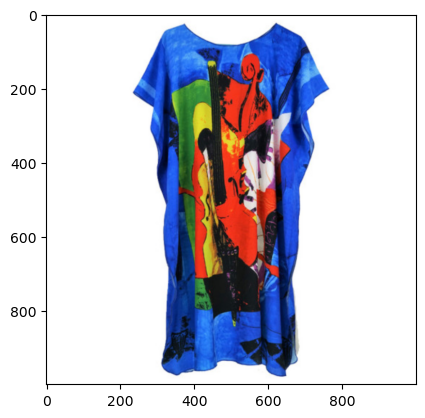

(1000, 1000, 3)


In [3]:
image = cv2.imread('./product_images/color_test_0009.jpg', cv2.IMREAD_UNCHANGED)
image = cv2.resize(image, (1000, 1000))

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.imread('./product_images/color_test_0009.jpg', cv2.IMREAD_GRAYSCALE)
image_gray = cv2.resize(image_gray, (1000, 1000))
# plt.imshow(image_gray, cmap = 'gray')
plt.imshow(image_rgb)
plt.show()
print(image_rgb.shape)

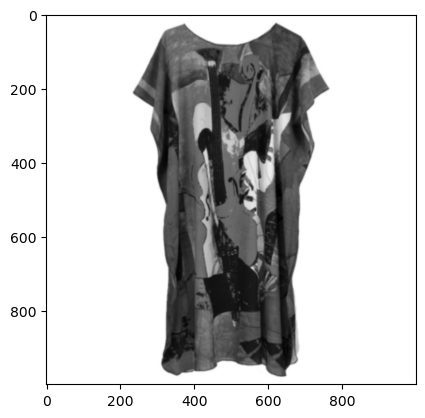

In [4]:
# smoothing
blur = cv2.GaussianBlur(image_gray, ksize = (5,5), sigmaX = 0)
ret, threshl = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY)
plt.imshow(blur, cmap = 'gray')
plt.show()

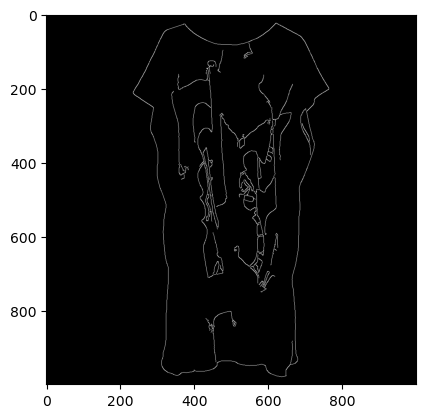

In [5]:
edged = cv2.Canny(blur, 10, 250)
edged = cv2.resize(edged, (1000, 1000))
plt.imshow(edged, cmap = 'gray')
plt.show()

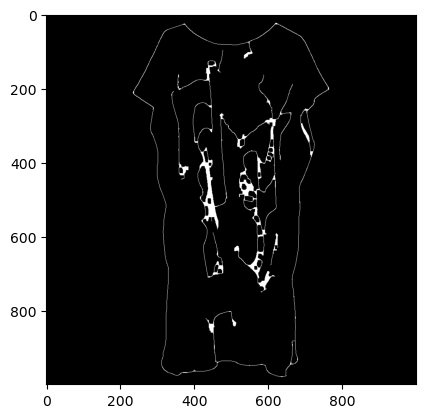

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed, cmap = 'gray')
plt.show()

In [7]:
contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_xy = np.array(contours)
contours_xy.shape

(1, 1089, 1, 2)

In [9]:
x_min, x_max = 0, 0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][0])
        x_min = min(value)
        x_max = max(value)

y_min, y_max = 0, 0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][1])
        y_min = min(value)
        y_max = max(value)

x = x_min
y = y_min
w = x_max-x_min
h = y_max-y_min

img_trim = image_rgb[y : y + h, x : x + w]

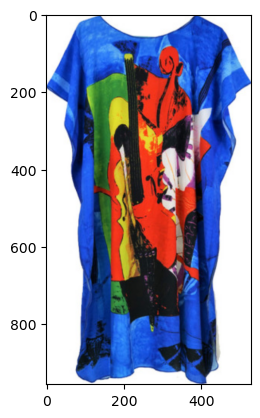

In [10]:
plt.imshow(img_trim)
plt.show()

In [11]:
rectangle = (x, y, w, h)

mask = np.zeros(image_rgb.shape[:2], np.uint8)

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

cv2.grabCut(image_rgb, 
           mask,       
           rectangle,  
           bgdModel,   
           fgdModel,   
           5,          
           cv2.GC_INIT_WITH_RECT) 

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[9.52729646e-01, 6.34726140e-03, 2.96375286e-02, 6.17287761e-06,
         1.12793906e-02, 2.55000000e+02, 2.55000000e+02, 2.55000000e+02,
         1.69371019e+02, 1.82763919e+02, 2.18083151e+02, 2.53713096e+02,
         2.53694975e+02, 2.52969852e+02, 1.25000000e+02, 1.51750000e+02,
         2.03250000e+02, 2.45142564e+02, 2.47161718e+02, 2.47261732e+02,
         1.00000000e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.00000000e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.00000000e-02, 1.26415605e+03, 1.09941509e+03, 4.58202313e+02,
         1.09941509e+03, 9.93285136e+02, 4.52892959e+02, 4.58202313e+02,
         4.52892959e+02, 3.12420997e+02, 1.06186704e+00, 3.43728910e-01,
         4.51542948e-01, 3.43728910e-01, 9.9

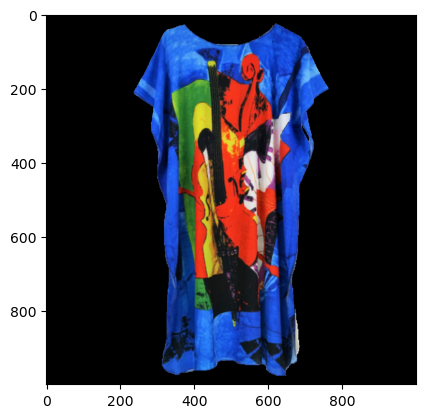

In [26]:
mask_2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]

plt.imshow(image_rgb_nobg)
plt.show()

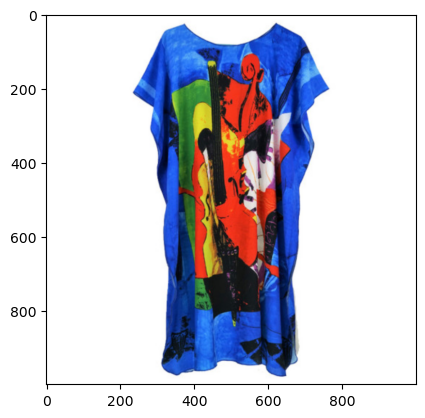

In [27]:
plt.imshow(image_rgb)

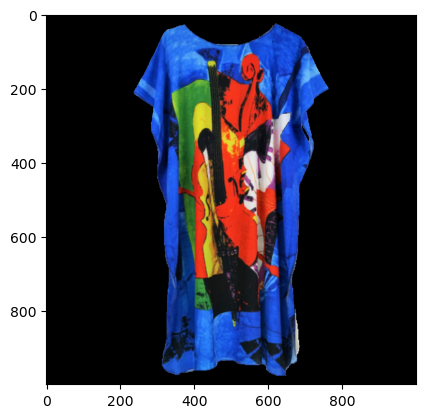

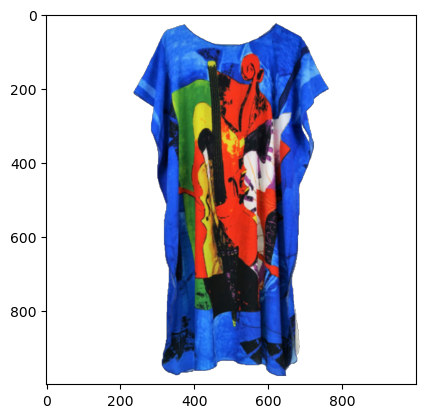

In [28]:
mask_2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]

plt.imshow(image_rgb_nobg)
plt.show()

img_rgba = cv2.cvtColor(image_rgb_nobg, cv2.COLOR_RGB2RGBA)

r_channel, g_channel, b_channel, alpha_channel = cv2.split(img_rgba)

alpha_channel = np.ones(b_channel.shape, dtype = b_channel.dtype) * 0

for i in range(1000) :
    for j in range(1000) :
        if mask_2[i][j] == 1 :
            alpha_channel[i][j] = 255

img_rgba = cv2.merge((r_channel, g_channel, b_channel, alpha_channel))

plt.imshow(img_rgba)

351011


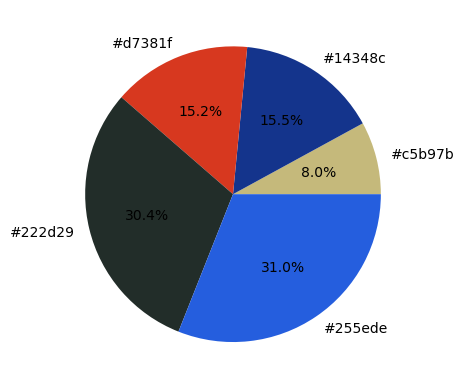

In [29]:
cluster_num = 5

data = []
for i in range(1000) :
    for j in range(1000) :
        if img_rgba[i][j][3] != 0 :
            data.append(img_rgba[i][j])
print(len(data))

# n_image = np.reshape(image_rgb, (image_rgb.shape[0] * image_rgb.shape[1], 3))

clustering = KMeans(n_clusters = cluster_num)
clustering.fit(data)

labels = np.unique(clustering.labels_)

hist, _ = np.histogram(clustering.labels_, bins = np.arange(len(labels) + 1))

colors = []
hexlabels = []

for i in range(clustering.cluster_centers_.shape[0]) :
    colors.append(tuple(clustering.cluster_centers_[i] / 255))
    hexlabels.append(cs.to_hex(tuple(clustering.cluster_centers_[i] / 255)))

plt.pie(hist, labels = hexlabels, colors = colors, autopct = '%1.1f%%')
plt.show()

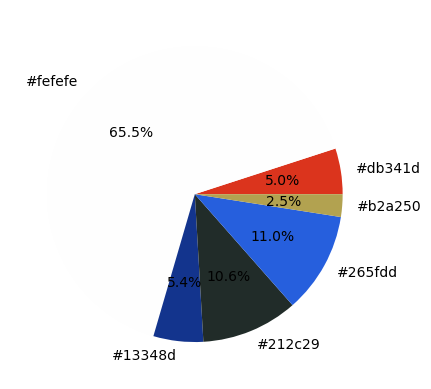

In [31]:
cluster_num = 6

n_image = np.reshape(image_rgb, (image_rgb.shape[0] * image_rgb.shape[1], 3))

clustering = KMeans(n_clusters = cluster_num)
clustering.fit(n_image)

labels = np.unique(clustering.labels_)

hist, _ = np.histogram(clustering.labels_, bins = np.arange(len(labels) + 1))

colors = []
hexlabels = []

for i in range(clustering.cluster_centers_.shape[0]) :
    colors.append(tuple(clustering.cluster_centers_[i] / 255))
    hexlabels.append(cs.to_hex(tuple(clustering.cluster_centers_[i] / 255)))

plt.pie(hist, labels = hexlabels, colors = colors, autopct = '%1.1f%%')
plt.show()